# Exploratory analysis of univariate and compound events

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '00:10:00'
cores = 4
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])
                     # python=os.environ["DASK_PYTHON"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.13:46871,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import warnings

import xarray as xr
import numpy as np
import geopandas

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [9]:
%cd /g/data/w42/dr6273/work/AEMO_compound_events/

import functions as fn

/g/data/w42/dr6273/work/AEMO_compound_events


In [10]:
season_dict = fn.get_seasons()

plt_params = fn.get_plot_params()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Load REZ and city shapefiles

In [11]:
rez_file = '/g/data/w42/dr6273/work/data/REZ_boundaries_2021/Indicative_REZ_boundaries_2021_-_GIS_data-polygon.shp'
rez_gpd = geopandas.read_file(rez_file)

Add central coords of REZ regions

In [12]:
rez_gpd['coords'] = rez_gpd['geometry'].apply(lambda x: x.representative_point().coords[:])
rez_gpd['coords'] = [coords[0] for coords in rez_gpd['coords']]

Add column of energy type codes

In [13]:
region_codes = [
    3, 7, 3, 3, 2, 2, 4, 4,     # NSW
    1, 1, 1, 1,                 # Offshore wind
    5, 7, 6, 7, 3, 7, 6, 3, 7,  # QLD
    1, 3, 1, 1, 4, 3, 2, 3, 3,  # SA
    3, 7, 7,                    # TAS
    6, 3, 1, 1, 3, 2            # VIC
]

In [14]:
rez_gpd['energy_code'] = 0

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    rez_gpd['energy_code'].iloc[9:17] = region_codes[:8]
    rez_gpd['energy_code'].iloc[[33, 34, 37, 38]] = region_codes[8:12]
    rez_gpd['energy_code'].iloc[:9] = region_codes[12:21]
    rez_gpd['energy_code'].iloc[23:32] = region_codes[21:30]
    rez_gpd['energy_code'].iloc[[32, 35, 36]] = region_codes[30:33]
    rez_gpd['energy_code'].iloc[17:23] = region_codes[33:]

In [16]:
gccsa_file = '/g/data/w42/dr6273/work/data/ABS_GCCSA_2021/GCCSA_2021_AUST_GDA2020.shp'
gccsa_gpd = geopandas.read_file(gccsa_file)

In [17]:
gccsa_gpd = gccsa_gpd.loc[
    (gccsa_gpd['GCC_NAME21'] == 'Greater Sydney') |
    (gccsa_gpd['GCC_NAME21'] == 'Greater Melbourne') |
    (gccsa_gpd['GCC_NAME21'] == 'Greater Brisbane') |
    (gccsa_gpd['GCC_NAME21'] == 'Greater Adelaide') |
    (gccsa_gpd['GCC_NAME21'] == 'Australian Capital Territory') |
    (gccsa_gpd['GCC_NAME21'] == 'Greater Hobart')
]

In [18]:
def plot_REZ_GCCSA(ax):
    """
    Plot REZ and GCCSA shape files with labels.
    """
    ax.set_extent([132, 160.01, -9, -46])
    ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='none',
        edgecolor='k',
        lw=.2,
        rasterized=True
    )
    ax.coastlines(resolution="50m", lw=0.5, rasterized=True)
    
    ax.set_xticks(np.arange(135, 161, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-10, -46, -5), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    alpha=0.6
    for i in range(len(rez_gpd)):
        d = rez_gpd.iloc[i:i+1]
        code = d.iloc[0]['energy_code']
        if (code == 1) | (code == 5):
            d.plot(ax=ax, alpha=alpha, color=colors[0], label='Wind', rasterized=True)
        elif (code == 2) | (code == 6):
            d.plot(ax=ax, alpha=alpha, color=colors[1], label='Solar', rasterized=True)
        elif (code == 3) | (code == 7):
            d.plot(ax=ax, alpha=alpha, color=colors[4], label='Wind and solar', rasterized=True)
        elif code == 4:
            pass
        else:
            raise ValueError('Incorrect code')
                        
    for idx, row in rez_gpd.iterrows():
        code = row['energy_code']
        label = row['Name'][:2]
        
        if label in ['O1', 'O2', 'Q1', 'Q3', 'Q6']:
            x = row.coords[0] + 1
            y = row.coords[1]
        elif label == 'O3':
            x = row.coords[0] + 1
            y = row.coords[1] - 0.5
        elif label == 'O4':
            x = row.coords[0]
            y = row.coords[1] + 0.5
        else:
            x = row.coords[0]
            y = row.coords[1]
            
        # if code != 4:
        #     ax.text(
        #         x,
        #         y,
        #         s=label,
        #         horizontalalignment='center',
        #         bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 0.5, 'edgecolor':'none'}
        #     )

    gccsa_gpd.plot(ax=ax, edgecolor=colors[3], facecolor=colors[3], alpha=alpha, rasterized=True)
    
    ax.text(138.5, -25.5, 'Queensland (QLD)')
    ax.text(141.5, -31, 'New South\nWales (NSW)')
    ax.text(132.5, -28.5, 'South\nAustralia (SA)')
    ax.text(134.5, -40.5, 'Victoria (VIC)')
    ax.text(138, -44.5, 'Tasmania (TAS)')
    ax.text(153, -38, 'Offshore')
    
    ax.text(154, -28, 'Brisbane')
    ax.text(154, -34, 'Sydney')
    ax.text(136.5, -42, 'Melbourne')
    ax.text(134.5, -38, 'Adelaide')
    ax.text(153, -36, 'Canberra')
    ax.text(148, -44, 'Hobart')
    
    ax.plot((151.7, 153.5), (-33.7, -33.7), c=colors[3]) # SYD
    ax.plot((142.2, 144.5), (-40.9, -38.5), c=colors[3]) # MLB
    ax.plot((141., 142), (-39.3, -38.5), c='k') # VIC
    ax.plot((138.5, 138.5), (-37, -36), c=colors[3]) # ADL
    ax.plot((149.5, 152.5), (-35.7, -35.7), c=colors[3]) # CBR
    
    # Offshore lines
    ax.plot((152.5, 152), (-37.7, -33.8), c=colors[0], ls='--')
    ax.plot((152.5, 151.4), (-37.7, -35), c=colors[0], ls='--')
    ax.plot((152.5, 148.2), (-37.7, -38.5), c=colors[0], ls='--')
    ax.plot((152.5, 145.9), (-37.7, -40.5), c=colors[0], ls='--')
    
    # Custom legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Solar',
                markerfacecolor=colors[1], markersize=12, alpha=alpha),
        Line2D([0], [0], marker='o', color='w', label='Wind',
                markerfacecolor=colors[0], markersize=12, alpha=alpha),
        Line2D([0], [0], marker='o', color='w', label='Solar and wind',
                markerfacecolor=colors[4], markersize=12, alpha=alpha)
    ]
    ax.legend(
        frameon=False,
        handles=legend_elements,
        loc=(0.55, 0.78),
        fontsize=plt_params['font.size'],
        labelspacing=.8
    )
    ax.set_title('(a) Renewable energy zones (REZs)\nand major cities')

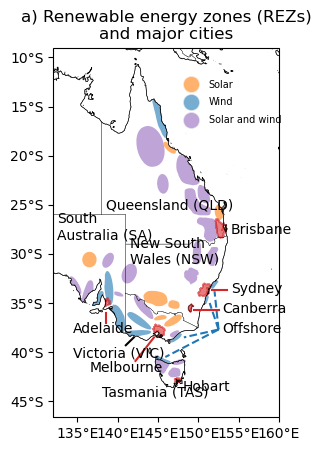

In [54]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
plot_REZ_GCCSA(ax)

# Load masks

In [19]:
rez_mask = fn.get_rez_mask()

In [20]:
gccsa_mask = fn.get_gccsa_mask()

# Load energy source and demand data

### REZ regions

In [21]:
years = range(1959, 2022)

Sources: daily wind, daily solar and monthly runoff

In [22]:
rez_100w = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/100w_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['100w'].compute()

In [23]:
rez_mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/mssrd_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['mssrd'].compute()

### Aus - gridded

In [24]:
aus_100w = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/100w/100w_era5_daily_1400UTC_sfc_1959-2021_AUS_region.zarr',
    consolidated=True
)['w100']

In [25]:
aus_mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/msdwswrf/msdwswrf_era5_daily_1400UTC_sfc_1959-2021_AUS_region.zarr',
    consolidated=True
)['msdwswrf']

# How often to regional means exceed operational thresholds?

In [79]:
def plot_freq(ax, da, title, mask, region_codes=None, vmin_vmax_interval='auto'):
    """
    Plot relative frequencies of events.
    """
    regions = da.region
    if isinstance(region_codes, list):
        regions = fn.get_regions_from_region_codes(region_codes, rez_mask)
    da = xr.where(mask.sel(region=regions),
                  da.sel(region=regions),
                  np.nan)
    da = da.sum('region', skipna=True)
    plot_da = da.where(mask.sel(region=regions).sum('region'))
    
    # Get data and colorbar limits
    if vmin_vmax_interval == 'auto':
        da_max = plot_da.max().values
        da_min = plot_da.min().values
        
        if da_min >= 0: # For positive data, this will lie 0-1
            cmap = 'RdBu_r'
            norm = matplotlib.colors.CenteredNorm(vcenter=0.25 ** 2)
            vmin = 0
            if da_max > 0.2:
                vmax = 0.5 * 100 #fn.round_decimals_up(da_max, 1)
                cbar_tick_intervals = 0.1 * 100
            elif da_max > 0.1:
                vmax = 0.25 ** 2 * 2 * 100 #fn.round_decimals_up(da_max, 2)
                cbar_tick_intervals = 0.02 * 100
            else:
                vmax = fn.round_decimals_up(da_max, 3) * 100
                cbar_tick_intervals = 0.001 * 100
        else: # Symmetric data
            cmap = 'RdBu_r'
            norm = None
            abs_max = np.max([np.abs(da_min), da_max])
            if abs_max > 0.2:
                vmax = fn.round_decimals_up(abs_max, 1) * 100
                cbar_tick_intervals = 0.1 * 100
            elif abs_max > 0.1:
                vmax = fn.round_decimals_up(abs_max, 1) * 100
                cbar_tick_intervals = 0.02 * 100
            else:
                vmax = fn.round_decimals_up(abs_max, 2) * 100
                cbar_tick_intervals = 0.01 * 100
            vmin = -vmax
                
    elif isinstance(vmin_vmax_interval, list):
        cmap = 'viridis'
        vmin = vmin_vmax_interval[0] * 100
        vmax = vmin_vmax_interval[1] * 100
        cbar_tick_intervals = vmin_vmax_interval[2] * 100
    else:
        raise ValueError("vmin_vmax_interval should be 'auto' or list with the \
        first element the desired vmin, and the second element vmax.")
                
    with plt.rc_context(plt_params):
        # ax.coastlines()
        ax.add_feature(
            cartopy.feature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces',
                                                scale='10m'),
            facecolor='gainsboro', edgecolor='k', lw=0.1,
            rasterized=True,
            zorder=0
        )
        ax.coastlines(lw=0.3, rasterized=True)

        p = (plot_da * 100).plot(ax=ax, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, add_colorbar=False, rasterized=True)
        
        # Colorbar
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        axins = inset_axes(ax, width="10%", height="100%",
                           bbox_to_anchor=(1.03, .01, .5, .99),
                           bbox_transform=ax.transAxes, loc='lower left', borderpad=0)
        cb1 = matplotlib.colorbar.ColorbarBase(ax=axins, cmap=cmap, norm=norm,
                                               ticks=np.arange(vmin, vmax+cbar_tick_intervals, cbar_tick_intervals),
                                               orientation='vertical')
        ax.set_title(title)

In [27]:
thresh_100w = rez_100w.quantile(0.25, ['time', 'region']) #4 # Close to all region-time 25th percentile of 4.19
thresh_mssrd = rez_mssrd.quantile(0.25, ['time', 'region']) #170 # All region-time 25th percentile is 132.7

### Frequencies of univariate events

In [28]:
freq_100w = fn.calculate_event_frequency(rez_100w, thresh_100w, tail='lower')

In [29]:
freq_mssrd = fn.calculate_event_frequency(rez_mssrd, thresh_mssrd, tail='lower')

### Frequencies of compound wind and solar lulls

In [30]:
freq_100w_mssrd = fn.calculate_compound_frequency(
    rez_100w, rez_mssrd, thresh_100w, thresh_mssrd)

### Events

In [33]:
events_100w = fn.get_events(rez_100w, thresh_100w, tail='lower')
events_mssrd = fn.get_events(rez_mssrd, thresh_mssrd, tail='lower')
events_100w_mssrd = fn.get_compound_events(rez_100w, rez_mssrd, thresh_100w, thresh_mssrd)

### Daily events over all regions

In [34]:
simul_100w = fn.concurrent_lulls(events_100w, [1, 3, 5, 7], rez_mask)
simul_mssrd = fn.concurrent_lulls(events_mssrd, [2, 3, 6, 7], rez_mask)
simul_100w_mssrd = fn.concurrent_lulls(events_100w_mssrd, [3, 7], rez_mask)

In [35]:
simul_100w_CE = fn.concurrent_univariate_or_compound_lulls(
    events_100w_mssrd, events_100w, [1, 3, 5, 7], rez_mask)

In [36]:
simul_mssrd_CE = fn.concurrent_univariate_or_compound_lulls(
    events_100w_mssrd, events_mssrd, [2, 3, 6, 7], rez_mask)

In [37]:
all_events_no_compound = fn.get_all_events(events_100w, events_mssrd, False)
all_events = fn.get_all_events(events_100w, events_mssrd, True)

In [50]:
def hist_plot(ax, da, months, color, label, vline=None,
              fill_alpha=0.3, xlim=39, time_name='time', zorder=0):
    """
    Plot histogram.
    """
    subset_da = fn.month_subset(da, months, time_name)
    b = np.linspace(0, subset_da.max().values, subset_da.max().values + 1)
    bins, hist = fn.hist_data(subset_da, b)
    
    ax.plot(bins, hist, color=color, label=label, zorder=zorder)
    ax.fill_between(bins, 0, hist, color=color, alpha=fill_alpha, zorder=zorder)
    
    if isinstance(vline, float):
        v = subset_da.quantile(vline, 'time')
        ax.axvline(v, ls='--', color=color)
    
    ymax = fn.round_decimals_up(hist.max().values, 1)
    ax.set_ylim(0, ymax)
    ax.set_yticks(np.arange(0, ymax+0.01, 0.2))
    
    ax.set_xlim(0, xlim+0.5)
    ax.set_xticks(np.arange(0, xlim+0.5, 5))
    
    return hist

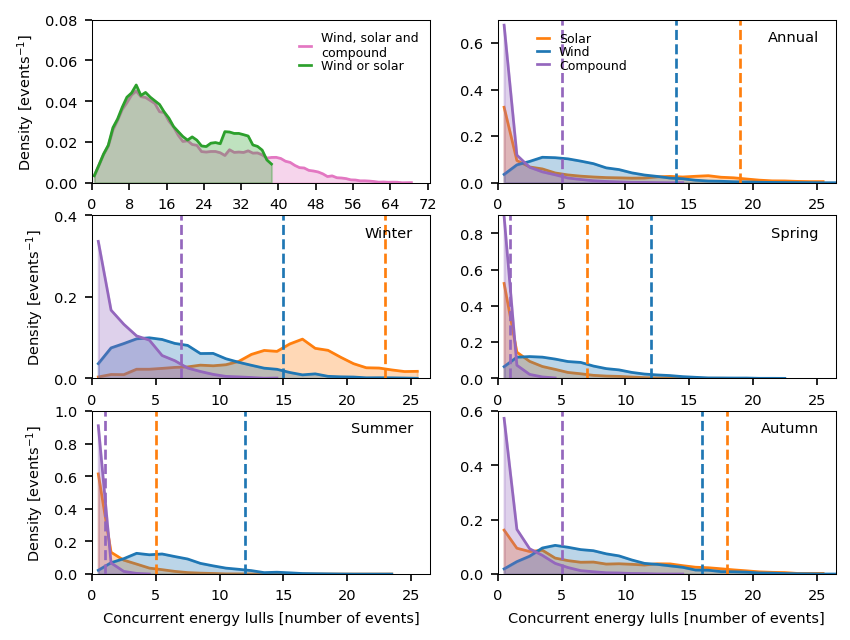

In [53]:
with plt.rc_context(plt_params):
    fig = plt.figure(1, dpi=150)
    
    # Wind and solar events together, with and without double counting of compound events
    # ========================================
    ax = fig.add_subplot(321)
    hist_plot(ax, all_events, season_dict['Annual'], colors[6], 'Wind, solar and\ncompound', xlim=72)
    hist_plot(ax, all_events_no_compound, season_dict['Annual'], colors[2], 'Wind or solar', xlim=72)
    ax.set_xticks(np.arange(0, 73, 8))
    ax.set_ylim(0, 0.08)
    ax.set_yticks(np.arange(0, 0.09, 0.02))
    # ax.set_xlabel('Concurrent energy lulls [number of events]')
    
    ax.legend(frameon=False)
    ax.set_ylabel(r'Density [events$^{-1}$]')
    
    # Wind solar and compound events by season
    # ========================================
    axes = [fig.add_subplot(321 + i) for i in [1, 2, 3, 4, 5]]
    
    for (ax, months, title) in zip(axes, season_dict.values(), season_dict.keys()):
    
        p1 = hist_plot(ax, simul_mssrd, months, colors[1], 'Solar', vline=0.95)
        p2 = hist_plot(ax, simul_100w, months, colors[0], 'Wind', vline=0.95)
        p3 = hist_plot(ax, simul_100w_mssrd, months, colors[4], 'Compound', vline=0.95)
        
        ymax = np.max([p1.max(), p2.max(), p3.max()])
        ax.set_ylim(0, fn.round_decimals_up(ymax, 1))
        ax.text(0.95, 0.85, title, transform=ax.transAxes, ha='right', va='bottom')
        
        ax.set_xlim(0, 26.5)
        ax.set_xticks(np.arange(0, 27, 5))
        # ax.set_xticklabels(np.arange(0, 27, 5))
        
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles, labels, loc=(0.1, 0.65), frameon=False)
    
    for ax in [axes[i] for i in [1, 3]]:
        ax.set_ylabel(r'Density [events$^{-1}$]')
    for ax in [axes[i] for i in [3, 4]]:
        ax.set_xlabel('Concurrent energy lulls [number of events]')
        
    # plt.subplots_adjust(hspace=0.5)

### Some stats

Cumulative probabilities of droughts over all REZs (green and pink curves from figure)

In [50]:
n = len(all_events_no_compound.time)
n

23011

In [66]:
counts1 = np.bincount(all_events_no_compound)
pcs1 = counts1 / n * 100

In [67]:
counts2 = np.bincount(all_events)
pcs2 = counts2 / n * 100

In [68]:
print(np.round(pcs1, 2))

[0.34 0.87 1.41 1.84 2.7  3.13 3.71 4.2  4.41 4.8  4.28 4.43 4.2  4.02
 3.84 3.47 3.17 2.76 2.51 2.27 2.09 2.25 2.09 1.81 1.78 1.94 1.97 1.92
 2.51 2.49 2.42 2.42 2.36 2.29 1.86 1.79 1.6  1.12 0.54 0.37]


In [69]:
print(np.round(np.cumsum(pcs1), 2))

[  0.34   1.21   2.62   4.46   7.17  10.3   14.    18.2   22.61  27.4
  31.69  36.12  40.32  44.34  48.19  51.66  54.83  57.59  60.1   62.37
  64.46  66.72  68.81  70.61  72.39  74.33  76.31  78.22  80.73  83.22
  85.64  88.06  90.42  92.72  94.57  96.36  97.96  99.08  99.63 100.  ]


In [72]:
len(pcs2)

70

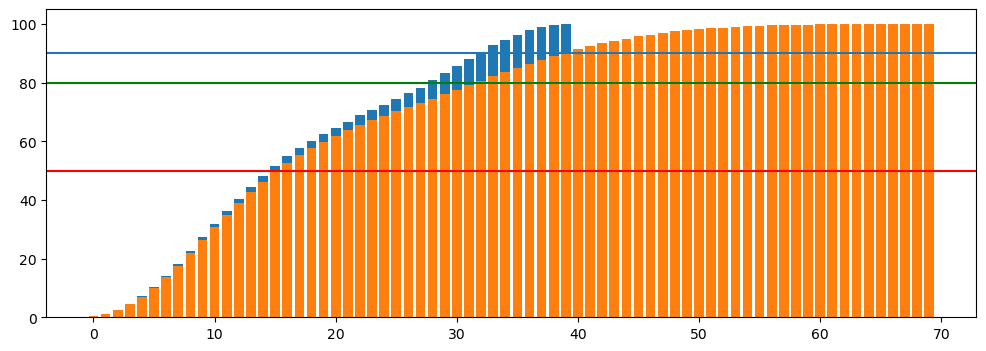

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.bar(range(40), np.cumsum(pcs1))
ax.bar(range(70), np.cumsum(pcs2))
ax.axhline(50, c='r')
ax.axhline(80, c='g')
ax.axhline(90)

Compound drought probabilities in winter

In [80]:
da = fn.month_subset(simul_100w_mssrd, [6, 7, 8])
n = len(da.time)

counts3 = np.bincount(da)
pcs3 = counts3 / n * 100

5796


In [85]:
pcs3

array([33.62663906, 16.75293306, 13.28502415, 10.43823326,  9.40303658,
        5.62456867,  4.34782609,  2.55348516,  1.70807453,  1.00069013,
        0.50034507,  0.37957212,  0.22429262,  0.05175983,  0.06901311,
        0.03450656])

In [97]:
# Prob of over 5 simultaneous droughts
np.sum(pcs3[6:])

10.869565217391303

In [90]:
pcs3[5:10]


array([5.62456867, 4.34782609, 2.55348516, 1.70807453, 1.00069013])

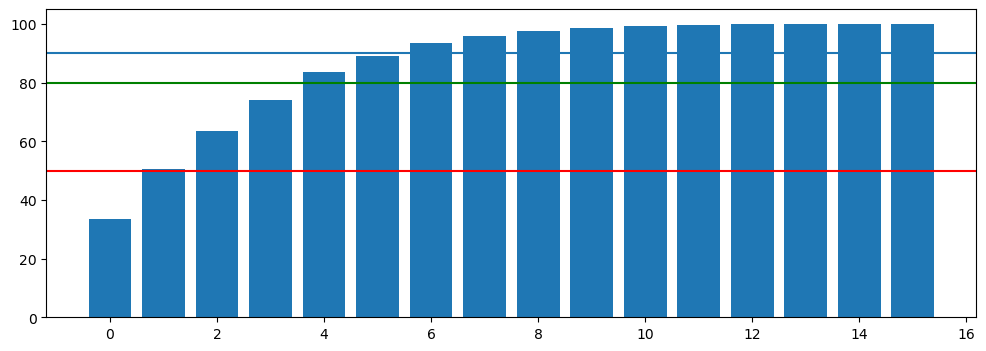

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.bar(range(16), np.cumsum(pcs3))
ax.axhline(50, c='r')
ax.axhline(80, c='g')
ax.axhline(90)

# Combine various plots

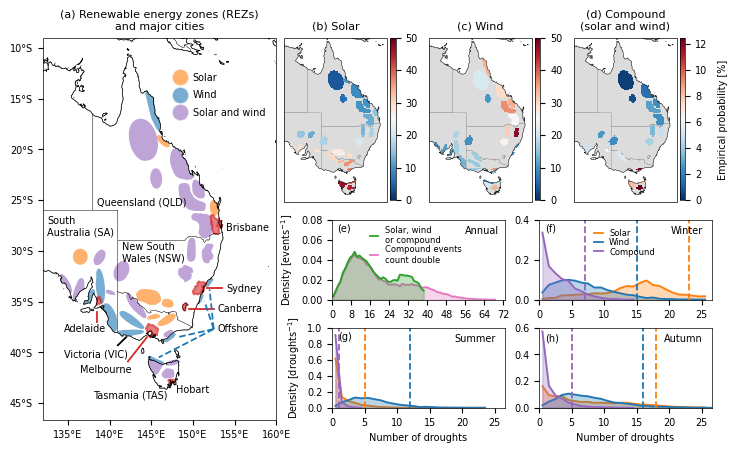

In [74]:
with plt.rc_context(plt_params):
    fig = plt.figure(dpi=100, figsize=(6.9, 4)) 
    
    # REZ and city plot
    gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0, right=0.4, bottom=0, top=.955)
    ax1 = plt.subplot(gs1[0], projection=ccrs.PlateCarree())
    plot_REZ_GCCSA(ax1)
    
    # Lull probabilities
    adj = 0.05 
    gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.38, right=0.53, bottom=0.5, top=1)
    ax2 = plt.subplot(gs2[0], projection=ccrs.PlateCarree())
    plot_freq(ax2, freq_mssrd, '(b) Solar', mask=rez_mask, region_codes=[2, 3, 6, 7])
    
    gs3 = fig.add_gridspec(nrows=1, ncols=1, left=0.59, right=0.74, bottom=0.5, top=1)
    ax3 = plt.subplot(gs3[0], projection=ccrs.PlateCarree())
    plot_freq(ax3, freq_100w, '(c) Wind', mask=rez_mask, region_codes=[1, 3, 5, 7])
    
    gs4 = fig.add_gridspec(nrows=1, ncols=1, left=0.8, right=0.95, bottom=0.5, top=1)
    ax4 = plt.subplot(gs4[0], projection=ccrs.PlateCarree())
    plot_freq(ax4, freq_100w_mssrd, '(d) Compound\n(solar and wind)', mask=rez_mask, region_codes=[3, 7])
    
    ax4.text(1.4, 0.5, 'Empirical probability [%]', rotation=90, fontsize=plt_params['font.size'],
             transform=ax4.transAxes, va='center', ha='left')
    
    # PDFs of simultaneous events
    # Wind and solar events together, with and without double counting of compound events
    # ========================================
    gs5 = fig.add_gridspec(nrows=1, ncols=1, left=0.45, right=0.7, bottom=0.3, top=0.5)
    ax5 = plt.subplot(gs5[0])
    hist_plot(ax5, all_events_no_compound, season_dict['Annual'],
              colors[2], 'Solar, wind\nor compound', xlim=72, zorder=1)
    hist_plot(ax5, all_events, season_dict['Annual'],
              colors[6], 'Compound events\ncount double', xlim=72, zorder=0)
    ax5.set_xticks(np.arange(0, 73, 8))
    ax5.set_ylim(0, 0.08)
    ax5.set_yticks(np.arange(0, 0.09, 0.02))
    # ax.set_xlabel('Concurrent energy lulls [number of events]')
    ax5.legend(loc=(0.2, 0.4), frameon=False)
    ax5.set_ylabel(r'Density [events$^{-1}$]')
    ax5.text(56, 0.066, 'Annual')
    
    # Wind solar and compound events by season
    # ========================================
    gs_list = [
        fig.add_gridspec(nrows=1, ncols=1, left=0.75, right=1, bottom=0.3, top=0.5),
        fig.add_gridspec(nrows=1, ncols=1, left=0.45, right=0.7, bottom=0.03, top=0.23),
        fig.add_gridspec(nrows=1, ncols=1, left=0.75, right=1, bottom=0.03, top=0.23),
        # fig.add_gridspec(nrows=1, ncols=1, left=0.45, right=0.7, bottom=0., top=0.1),
        # fig.add_gridspec(nrows=1, ncols=1, left=0.75, right=1, bottom=0., top=0.1)
    ]
    axes = [fig.add_subplot(gs[0]) for gs in gs_list]
    
    plot_seasons = season_dict.copy()
    plot_seasons.pop('Annual')
    plot_seasons.pop('Spring')
    
    for (gs, ax, months, title) in zip(gs_list, axes, plot_seasons.values(), plot_seasons.keys()):
    
        p1 = hist_plot(ax, simul_mssrd, months, colors[1], 'Solar', vline=0.95)
        p2 = hist_plot(ax, simul_100w, months, colors[0], 'Wind', vline=0.95)
        p3 = hist_plot(ax, simul_100w_mssrd, months, colors[4], 'Compound', vline=0.95)
        
        ymax = np.max([p1.max(), p2.max(), p3.max()])
        ax.set_ylim(0, fn.round_decimals_up(ymax, 1))
        ax.text(0.95, 0.8, title, transform=ax.transAxes, ha='right', va='bottom')
        
        ax.set_xlim(0, 26.5)
        ax.set_xticks(np.arange(0, 27, 5))
        # ax.set_xticklabels(np.arange(0, 27, 5))
        
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles, labels, loc=(0.3, 0.5), frameon=False)
    
    for ax in [axes[i] for i in [1]]:
        ax.set_ylabel(r'Density [droughts$^{-1}$]')
    for ax in [axes[i] for i in [1, 2]]:
        ax.set_xlabel('Number of droughts')
        
    ax5.text(2, 0.068, '(e)')
    axes[0].text(1, 0.34, '(f)')
    axes[1].text(1, 0.85, '(g)')
    axes[2].text(1, 0.5, '(h)')            
        
    plt.savefig('./figures/Fig1_statistics.pdf', format='pdf', dpi=400, bbox_inches='tight')

# Close cluster

In [59]:
client.close()
cluster.close()